In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from scipy import constants

In [86]:
def calculate_E_field(power, beam_waist):
    intensity = 2 * power / (np.pi * beam_waist**2)
    E_field = np.sqrt(2 * intensity / (constants.c * constants.epsilon_0))
    return E_field

def calculate_rabi_frequency(dipole_matrix_element, E_field):
    return dipole_matrix_element * E_field / constants.hbar

def simulate_raman_gate(
    power_649: float,  # Watts
    power_770: float,  # Watts
    w0_649: float,  # meters
    w0_770: float,  # meters
    polarization_649: str,  # 'pi', 'sigma_plus'
    polarization_770: str,  # 'pi', 'sigma_plus'
    detuning: float,  # Hz
    detuning_offset: float,  # Hz
    initial_states: list[str],  # ['00', '01', '10', '11'] or any subset
    num_steps: int,
    gate_time: float = None
):
    
    
    freq_scale = 1e9  # GHz
    
    # =========================
    # Initialize energy levels 
    # =========================
    # NOTE: hard-coded for 5G magnetic field
    
    levels = [
        # 3P0 sublevels
        {'level': '3P0', 'F': 1/2, 'mF': 1/2,  'energy_Hz': 0},
        {'level': '3P0', 'F': 1/2, 'mF': -1/2, 'energy_Hz': 3749.528976851414},
        # 3S1 sublevels
        {'level': '3S1', 'F': 1/2, 'mF': 1/2,  'energy_Hz': 461850274160685.7},
        {'level': '3S1', 'F': 1/2, 'mF': -1/2, 'energy_Hz': 461850292913971.44},
        {'level': '3S1', 'F': 3/2, 'mF': 3/2,  'energy_Hz': 461860484233885.6},
        {'level': '3S1', 'F': 3/2, 'mF': 1/2,  'energy_Hz': 461860493612403.4},
        {'level': '3S1', 'F': 3/2, 'mF': -1/2, 'energy_Hz': 461860502990920.8},
        {'level': '3S1', 'F': 3/2, 'mF': -3/2, 'energy_Hz': 461860512369438.56},
        # 3P2 sublevels
        {'level': '3P2', 'F': 3/2, 'mF': 3/2,  'energy_Hz': 72602523903671.75},
        {'level': '3P2', 'F': 3/2, 'mF': 1/2,  'energy_Hz': 72602536499251.66},
        {'level': '3P2', 'F': 3/2, 'mF': -1/2, 'energy_Hz': 72602549094831.69},
        {'level': '3P2', 'F': 3/2, 'mF': -3/2, 'energy_Hz': 72602561690411.6},
        {'level': '3P2', 'F': 5/2, 'mF': 5/2,  'energy_Hz': 72609214146883.69},
        {'level': '3P2', 'F': 5/2, 'mF': 3/2,  'energy_Hz': 72609222545186.78},
        {'level': '3P2', 'F': 5/2, 'mF': 1/2,  'energy_Hz': 72609230943489.86},
        {'level': '3P2', 'F': 5/2, 'mF': -1/2, 'energy_Hz': 72609239341793.05},
        {'level': '3P2', 'F': 5/2, 'mF': -3/2, 'energy_Hz': 72609247740096.14},
        {'level': '3P2', 'F': 5/2, 'mF': -5/2, 'energy_Hz': 72609256138399.22},
    ]

    N = len(levels)
    basis_states = []
    for i, level in enumerate(levels):
        new_row = level.copy()
        new_row['basis'] = basis(N, i)
        basis_states.append(new_row)
    basis_states = pd.DataFrame(basis_states)
    
    # set intermediate and excited states for Raman gate
    # depending on the polarization of 649 and 770
    if polarization_649 == 'pi':
        q1 = 0
    elif polarization_649 == 'sigma_plus':
        q1 = 1
    else:
        raise ValueError(f'Invalid 649 polarization: {polarization_649}')
    if polarization_770 == 'pi':
        q2 = 0
    elif polarization_770 == 'sigma_plus':
        q2 = 1
    else:
        raise ValueError(f'Invalid 649 polarization: {polarization_770}')
    reference_state_3s1 = basis_states[(basis_states['level'] == '3S1') & \
                                       (basis_states['F'] == 1.5) & \
                                       (basis_states['mF'] == (0.5 + q1))]
    reference_state_3p2 = basis_states[(basis_states['level'] == '3P2') & \
                                       (basis_states['F'] == 2.5) & \
                                       (basis_states['mF'] == (0.5 + q1 + q2))]
        
    # ==============================
    # matrix elements [atomic units]
    # ==============================
    
    # level1 = 3P0 -> level2 = 3S1
    pi_matrix_elements_649 = [
        {'F1': 1/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 0.660000},
        {'F1': 1/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': -0.660000},
        {'F1': 1/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': -0.933381},
        {'F1': 1/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': -0.933381},
    ]
    sigma_p_matrix_elements_649 = [
        {'F1': 1/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': 1/2, 'matrix_element': 0.933381},
        {'F1': 1/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': 1/2, 'matrix_element': 0.660000},
        {'F1': 1/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 3/2, 'matrix_element': 1.143154},
    ]
    # level1 = 3P2 -> level2 = 3S1 
    pi_matrix_elements_770 = [
        {'F1': 3/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 1.683333},
        {'F1': 3/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 1.683333},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 3/2, 'matrix_element': -0.714178},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': -0.238059},
        {'F1': 3/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 0.238059},
        {'F1': 3/2, 'F2': 3/2, 'mF1': -3/2, 'mF2': -3/2, 'matrix_element': 0.714178},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 3/2, 'matrix_element': 1.428356},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -3/2, 'mF2': -3/2, 'matrix_element': 1.428356},
    ]
    sigma_p_matrix_elements_770 = [
        {'F1': 3/2, 'F2': 1/2, 'mF1': 3/2, 'mF2': 1/2, 'matrix_element': 2.061654},
        {'F1': 3/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': -1/2, 'matrix_element': 1.190296},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 1/2, 'matrix_element': 0.583124},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': -1/2, 'matrix_element': 0.673333},
        {'F1': 3/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -3/2, 'matrix_element': 0.583124},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 5/2, 'mF2': 3/2, 'matrix_element': 2.258429},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': -1/2, 'matrix_element': 1.236992},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -3/2, 'matrix_element': 0.714178},
    ]
    
    if polarization_649 == 'pi':
        matrix_elements_649 = pi_matrix_elements_649
    elif polarization_649 == 'sigma_plus':
        matrix_elements_649 = sigma_p_matrix_elements_649
        
    if polarization_770 == 'pi':
        matrix_elements_770 = pi_matrix_elements_770
    elif polarization_649 == 'sigma_plus':
        matrix_elements_770 = sigma_p_matrix_elements_770

    # atomic units for dipole matrix element
    dipole_moment_si = constants.physical_constants['Bohr radius'][0] * constants.e

    # compute electric field at beam waist of 649nm laser
    E_field_649 = calculate_E_field(power_649, w0_649)
    # compute Rabi frequencies [Hz] for each transition
    rabi_frequencies_649 = []
    for row in matrix_elements_649:
        # copy row and remove matrix element
        new_row = row.copy()
        new_row.pop('matrix_element')
        # compute rabi frequency
        matrix_element = row['matrix_element'] * dipole_moment_si
        new_row['rabi_frequency'] = calculate_rabi_frequency(matrix_element, E_field_649)
        rabi_frequencies_649.append(new_row)
        
    # compute electric field at beam waist of 649nm laser
    E_field_770 = calculate_E_field(power_770, w0_770)
    # compute Rabi frequencies [Hz] for each transition
    rabi_frequencies_770 = []
    for row in matrix_elements_770:
        # copy row and remove matrix element
        new_row = row.copy()
        new_row.pop('matrix_element')
        # compute rabi frequency
        matrix_element = row['matrix_element'] * dipole_moment_si
        new_row['rabi_frequency'] = calculate_rabi_frequency(matrix_element, E_field_770)
        rabi_frequencies_770.append(new_row)
        
    # =====================
    # Construct Hamiltonian
    # =====================
    
    # Calculate light shift compensation
    Delta_LS = 0
    for transition in rabi_frequencies_649:
        if transition['F1'] == 1/2 and transition['mF1'] == 1/2:
            Delta_LS += transition['rabi_frequency']**2 / (4 * detuning)
    for transition in rabi_frequencies_770:
        if transition['F1'] == reference_state_3p2['F'].values[0] and transition['mF1'] == reference_state_3p2['mF'].values[0]:
            Delta_LS -= transition['rabi_frequency']**2 / (4 * detuning)
    # Add offset (for sweeping)
    Delta_LS += detuning_offset
    # Rescale
    Delta_LS /= freq_scale
    
    # Initialize Hamiltonian
    H = 0

    # 3P0 -> 3S1
    for transition in rabi_frequencies_649:
        Omega = transition['rabi_frequency'] / freq_scale
        state1 = basis_states[(basis_states['level'] == '3P0') & \
                            (basis_states['F'] == transition['F1']) & \
                            (basis_states['mF'] == transition['mF1'])]
        state2 = basis_states[(basis_states['level'] == '3S1') & \
                            (basis_states['F'] == transition['F2']) & \
                            (basis_states['mF'] == transition['mF2'])]
        # add coupling term
        basis1 = state1['basis'].values[0]
        basis2 = state2['basis'].values[0]
        coupling_term = (Omega / 2) * (basis1 * basis2.dag() + basis2 * basis1.dag())
        H += coupling_term
        
    # 3S1 -> 3P2
    for transition in rabi_frequencies_770:
        Omega = transition['rabi_frequency'] / freq_scale
        state1 = basis_states[(basis_states['level'] == '3P2') & \
                            (basis_states['F'] == transition['F1']) & \
                            (basis_states['mF'] == transition['mF1'])]
        state2 = basis_states[(basis_states['level'] == '3S1') & \
                            (basis_states['F'] == transition['F2']) & \
                            (basis_states['mF'] == transition['mF2'])]
        # add coupling term
        basis1 = state1['basis'].values[0]
        basis2 = state2['basis'].values[0]
        coupling_term = (Omega / 2) * (basis1 * basis2.dag() + basis2 * basis1.dag())
        H += coupling_term
        
    # add detunings
    for state in basis_states.to_records():
        if state['level'] in ['3P0', '3P2']:
            H += (detuning / freq_scale) * state['basis'] * state['basis'].dag()
        if state['level'] == '3S1':
            ref_detuning = (reference_state_3s1['energy_Hz'].values[0] - state['energy_Hz']) / freq_scale
            H += 2 * np.pi * ref_detuning * state['basis'] * state['basis'].dag()
        if state['level'] == '3P2':
            ref_detuning = (reference_state_3p2['energy_Hz'].values[0] - state['energy_Hz']) / freq_scale
            H += 2 * np.pi * ref_detuning * state['basis'] * state['basis'].dag()
            # add light shift compensation for resonance
            H += Delta_LS * state['basis'] * state['basis'].dag()
            
    # =======================
    # Simulate time evolution
    # =======================

    # calculate gate time
    gi_rabi_freq = [transition['rabi_frequency'] for transition in rabi_frequencies_649 \
        if transition['F1'] == 1/2 and transition['mF1'] == 1/2 and \
        transition['F2'] == reference_state_3s1['F'].values[0] and \
        transition['mF2'] == reference_state_3s1['mF'].values[0]][0]
    ie_rabi_freq = [transition['rabi_frequency'] for transition in rabi_frequencies_770 \
        if transition['F1'] == reference_state_3p2['F'].values[0] and \
        transition['mF1'] == reference_state_3p2['mF'].values[0] and \
        transition['F2'] == reference_state_3s1['F'].values[0] and \
        transition['mF2'] == reference_state_3s1['mF'].values[0]][0]
    
    Delta_avg = (detuning + (detuning + Delta_LS)) / 2
    raman_rabi_freq = (gi_rabi_freq * ie_rabi_freq) / (2 * Delta_avg) / freq_scale
    detuned_raman_rabi_freq = np.sqrt(raman_rabi_freq**2 + (detuning_offset/freq_scale)**2)
    print(f'Raman Rabi frequency: {np.abs(raman_rabi_freq) / 2 / np.pi * freq_scale / 1e6} MHz')
    print(f'Detuned Rabi frequency: {np.abs(detuned_raman_rabi_freq) / 2 / np.pi * freq_scale / 1e6} MHz')
    raman_gate_time = np.abs(2 * np.pi / detuned_raman_rabi_freq)
    
    qubit_basis_0 = basis_states[(basis_states['level'] == '3P0') & \
                                 (basis_states['F'] == 1/2) & \
                                 (basis_states['mF'] == -1/2)]['basis'].values[0]
    qubit_basis_1 = basis_states[(basis_states['level'] == '3P0') & \
                                 (basis_states['F'] == 1/2) & \
                                 (basis_states['mF'] == 1/2)]['basis'].values[0]

    rho_inital_dict = {
        '00': qubit_basis_0 * qubit_basis_0.dag(), 
        '01': qubit_basis_0 * qubit_basis_1.dag(), 
        '10': qubit_basis_1 * qubit_basis_0.dag(), 
        '11': qubit_basis_1 * qubit_basis_1.dag()
    }
    
    # Time vector
    if gate_time is not None:
        t_max = gate_time * freq_scale
    else:
        t_max = 1.2 * raman_gate_time
    t_list = np.linspace(0, t_max, num_steps)

    # Expectation operators
    e_ops = [state['basis'] * state['basis'].dag() for state in basis_states.to_records()]

    # Solve for the time evolution
    result_dict = {}
    for state in initial_states:
        result = mesolve(H, rho_inital_dict[state], t_list, e_ops=e_ops, options=dict(store_states=True))
        result_dict[state] = result
        
    # Construct return value
    output = {
        'basis_states': basis_states,
        't_list': t_list,
        'results': result_dict
    }
        
    return output

In [87]:
power_649 = 23.4e-3  # 649nm power [W]
power_770 = 23.4e-3  # 770nm power [W]
w0_649 = 500e-6  # 649nm beam waist [m]
w0_770 = 500e-6  # 770nm beam waist [m]
polarization_649 = 'pi'
polarization_770 = 'pi'
detuning = 2 * np.pi * 30 * 1e9  # Hz
initial_states = ['11']
num_steps = 2000

outputs = []
detuning_offsets = 2 * np.pi * np.linspace(0.01, 0.02, 5) * 1e6

for detuning_offset in detuning_offsets:
    output = simulate_raman_gate(
        power_649=power_649,
        power_770=power_770,
        w0_649=w0_649,
        w0_770=w0_770,
        polarization_649=polarization_649,
        polarization_770=polarization_770,
        detuning=detuning,
        detuning_offset=detuning_offset,
        initial_states=initial_states,
        num_steps=num_steps
    )
    outputs.append(output)

Raman Rabi frequency: 0.2000401435727402 MHz
Detuned Rabi frequency: 0.2002899374422053 MHz
Raman Rabi frequency: 0.2000401435727402 MHz
Detuned Rabi frequency: 0.2004303096854428 MHz
Raman Rabi frequency: 0.2000401435727402 MHz
Detuned Rabi frequency: 0.20060174236681622 MHz
Raman Rabi frequency: 0.2000401435727402 MHz
Detuned Rabi frequency: 0.20080415593458845 MHz
Raman Rabi frequency: 0.20004014357274016 MHz
Detuned Rabi frequency: 0.2010374568099251 MHz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


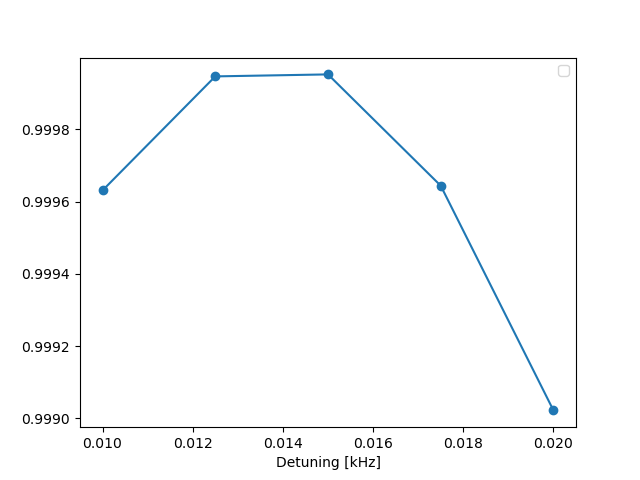

In [88]:
plt.figure()

inversions = []

for idx in range(len(outputs)):

    basis_states = outputs[idx]['basis_states']
    results = outputs[idx]['results']
    t_list = outputs[idx]['t_list']

    excited_idx = [i for i, state in enumerate(basis_states.to_records()) \
        if state['level'] == '3P2' and state['F'] == 2.5 and state['mF'] == 0.5][0]

    ys = results['11'].expect[excited_idx]
    gate_end_idx = num_steps//2 + np.argmin(ys[num_steps//2:])
    half_gate_idx = gate_end_idx // 2 
    
    inversions.append(ys[half_gate_idx])
    # plt.plot(t_list, ys, label=f'detuning = {detuning_offsets[idx] / 2 / np.pi / 1e6 :.3f} MHz')
    
plt.plot(detuning_offsets / 2 / np.pi / 1e6, inversions, 'o-')
# plt.hlines(y=1/2, xmin=np.min(detuning_offsets) / 2 / np.pi / 1e6, xmax=np.max(detuning_offsets) / 2 / np.pi / 1e6)
plt.xlabel('Detuning [kHz]')
plt.legend()

In [89]:
power_649 = 23.4e-3  # 649nm power [W]
power_770 = 23.4e-3  # 770nm power [W]
w0_649 = 500e-6  # 649nm beam waist [m]
w0_770 = 500e-6  # 770nm beam waist [m]
polarization_649 = 'pi'
polarization_770 = 'pi'
detuning = 2 * np.pi * 30 * 1e9  # Hz
initial_states = ['00', '01', '10', '11']
num_steps = 3000

detuning_offset = 2 * np.pi * 0.0138 * 1e6

output = simulate_raman_gate(
    power_649=power_649,
    power_770=power_770,
    w0_649=w0_649,
    w0_770=w0_770,
    polarization_649=polarization_649,
    polarization_770=polarization_770,
    detuning=detuning,
    detuning_offset=detuning_offset,
    initial_states=initial_states,
    num_steps=num_steps
)

Raman Rabi frequency: 0.2000401435727402 MHz
Detuned Rabi frequency: 0.2005155830368366 MHz


4998.784115378797


Text(0.5, 0, 'Time [ns]')

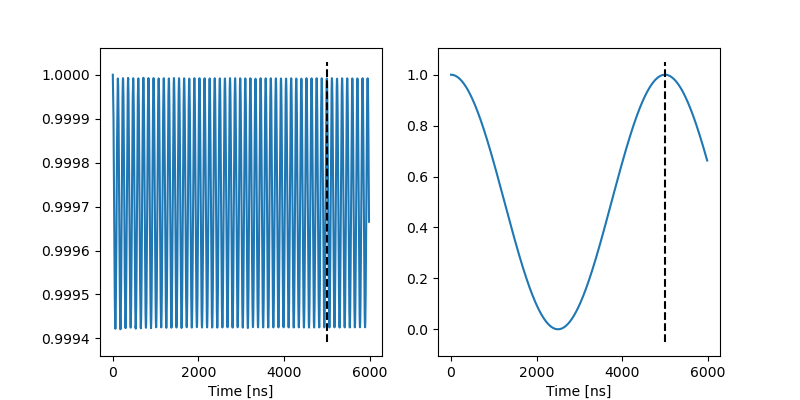

In [90]:
%matplotlib widget

basis_states = output['basis_states']
results = output['results']

ground_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P0' and state['F'] == 0.5 and state['mF'] == -0.5][0]
ground_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P0' and state['F'] == 0.5 and state['mF'] == 0.5][0]

intermediate_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3S1' and state['F'] == 1.5 and state['mF'] == -0.5][0]
intermediate_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3S1' and state['F'] == 1.5 and state['mF'] == 0.5][0]

excited_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P2' and state['F'] == 2.5 and state['mF'] == -0.5][0]
excited_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P2' and state['F'] == 2.5 and state['mF'] == 0.5][0]


ts = output['t_list']
ys_0 = results['00'].expect[ground_0_idx]
ys_1 = results['11'].expect[ground_1_idx]
gate_end_idx = num_steps//2 + np.argmax(ys_1[num_steps//2:])
print(ts[gate_end_idx])

fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))

ax[0].plot(ts, ys_0)
ax[1].plot(ts, ys_1)

ax[0].vlines(ts[gate_end_idx], *ax[0].get_ylim(), linestyle='--', color='black')
ax[1].vlines(ts[gate_end_idx], *ax[1].get_ylim(), linestyle='--', color='black')

# ax[1].hlines(0.5, *ax[1].get_xlim(), linestyle='--', color='black')

ax[0].set_xlabel('Time [ns]')
ax[1].set_xlabel('Time [ns]')

In [8]:
def calculate_fidelity(actual_superop: Qobj, ideal_superop: Qobj):
    vec = np.array(actual_superop[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    process_fidelity = 1/4 * Qobj(ideal_superop.dag()[:,:] @ actual_superop[:,:]).tr()
    return np.real((2 * process_fidelity + 1 - leakage) / 3)

# rho_final = {state: result.states[gate_end_idx] for state, result in results.items()}
# subspace_vector_final = {state: operator_to_vector(Qobj(rho[:2,:2]))[::-1,:] for state, rho in rho_final.items()}

# super_op_sim = Qobj(np.column_stack((
#     subspace_vector_final['00'], 
#     subspace_vector_final['10'], 
#     subspace_vector_final['01'], 
#     subspace_vector_final['11'])))

ideal_gate = Qobj(np.array([
    [1, 0, 0, 0],
    [0,-1, 0, 0],
    [0, 0,-1, 0],
    [0, 0, 0, 1]
]))

fidelity = calculate_fidelity(super_op_sim, ideal_gate)
fidelity
super_op_sim[:,:]

NameError: name 'super_op_sim' is not defined

In [16]:
rabi_freqs = [
    1.0,
    0.875,
    0.75,
    0.625,
    0.5,
    0.375,
    0.25,
    0.2,
    0.175,
    0.15,
    0.125,
    0.1,
]
fidelities = [
    0.9904780662537584,
    0.9909766838273271,
    0.9948990359846936,
    0.9951207587167538,
    0.9979761723276294,
    0.9983205864416114,
    0.9992071978232767,
    0.9997827228848525,
    0.9998220574419707,
    0.9999029804001095,
    0.9998631403094135,
    0.9999641732521134
]
super_ops = [
    np.array([
        [0.99270915+9.69619185e-17j, 0, 0, 0],
        [0, -0.97882625-1.85845878e-01j, 0, 0],
        [0, 0, -0.97882749+1.85846119e-01j, 0],
        [0, 0, 0, 0.99989818-1.86550651e-17j]]),
    np.array([
        [0.99117878+2.50038903e-13j, 0, 0, 0],
        [0, -0.98179062-1.65432628e-01j, 0, 0],
        [0, 0, -0.98179062+1.65432628e-01j, 0],
        [0, 0, 0, 0.99996065-1.34989044e-16j]]),
    np.array([
        [0.99604622-3.62873641e-13j, 0, 0, 0],
        [0, -0.98868321-1.36114478e-01j, 0, 0],
        [0, 0, -0.98868316+1.36114471e-01j, 0],
        [0, 0, 0, 0.9999677+5.97483221e-18j]]),
    np.array([
        [0.99448527-4.20302027e-18j, 0, 0, 0],
        [0, -0.99090621-1.12083675e-01j, 0, 0],
        [0, 0, -0.99090621+1.12083675e-01j, 0],
        [0, 0, 0, 0.9999708 +9.39386915e-18j]]),
    np.array([
        [0.99899923-3.86865728e-17j, 0, 0, 0],
        [0, -0.99495137-9.51310195e-02j, 0, 0],
        [0, 0, -0.99495149+9.51310335e-02j, 0],
        [0, 0, 0, 0.99997786+4.84860420e-19j]]),
    np.array([
        [0.99813786+6.36241396e-18j, 0, 0, 0],
        [0, -0.9968385 -6.66091616e-02j, 0, 0],
        [0, 0, -0.9968385 +6.66091616e-02j, 0],
        [0, 0, 0, 0.9999854 +1.49661037e-17j]]),
    np.array([
        [0.99919254+6.29021185e-19j, 0, 0, 0],
        [0, -0.99843895-4.79865514e-02j, 0, 0],
        [0, 0, -0.998439  +4.79865537e-02j, 0],
        [0, 0, 0, 0.99999008-1.86659978e-17j]]),
    np.array([
        [0.99999175-9.65435046e-18j, 0, 0, 0],
        [0, -0.99936442-3.54112604e-02j, 0, 0],
        [0, 0, -0.99936432+3.54112569e-02j, 0],
        [0, 0, 0, 0.99999205-2.23730790e-18j]]),
    np.array([
        [0.99999318-1.08553174e-18j, 0, 0, 0],
        [0, -0.99947995-3.20354779e-02j, 0, 0],
        [0, 0, -0.99947964+3.20354680e-02j, 0],
        [0, 0, 0, 0.9999932 +1.98816124e-18j]]),
    np.array([
        [0.99999186+9.18203663e-19j, 0, 0, 0],
        [0, -0.99972612-2.29065113e-02j, 0, 0],
        [0, 0, -0.99972768+2.29065472e-02j, 0],
        [0, 0, 0, 0.99999018+2.06818521e-17j]]),
    np.array([
        [0.99993079+1.56419213e-18j, 0, 0, 0],
        [0, -0.99966392-2.44510127e-02j, 0, 0],
        [0, 0, -0.99966392+2.44510127e-02j, 0],
        [0, 0, 0, 0.99999471-2.30922267e-17j]]),
    np.array([
        [0.99999407-1.01197297e-18j, 0, 0, 0],
        [0, -0.99990258-1.35970671e-02j, 0, 0],
        [0, 0, -0.99990237+1.35970642e-02j, 0],
        [0, 0, 0, 0.99999598-2.04211413e-17j]])
]


In [17]:
leakage_fidelities = []
phase_fidelities = []
prob_0_leakage = []
for M in super_ops:
    M2 = M.copy()
    prob_0_leakage.append(M2[0,0])
    M2[1,1] = -1 * np.sqrt((M2[0,0]**2 + M2[3,3]**2) / 2)
    M2[2,2] = -1 * np.sqrt((M2[0,0]**2 + M2[3,3]**2) / 2)
    fidelity = calculate_fidelity(M2, ideal_gate)
    leakage_fidelities.append(fidelity)
    M2 = M.copy()
    M2[0,0] = 1
    M2[3,3] = 1
    M2[1,1] = M2[1,1] / np.abs(M2[1,1])
    M2[2,2] = M2[2,2] / np.abs(M2[1,1])
    fidelity = calculate_fidelity(M2, ideal_gate)
    phase_fidelities.append(fidelity)
    


/Users/calebclothier/anaconda3/envs/quantum/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/calebclothier/anaconda3/envs/quantum/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


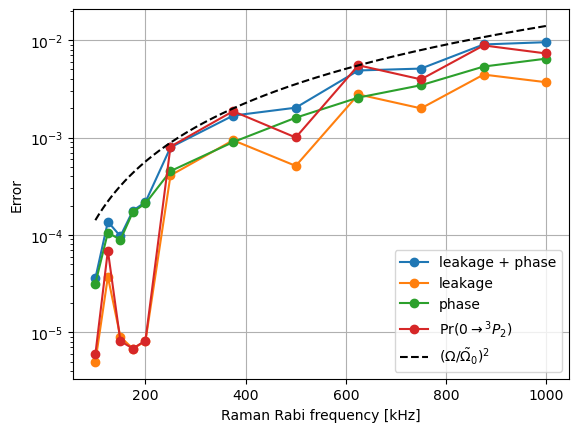

In [11]:
plt.figure()

xs = np.linspace(np.min(rabi_freqs), np.max(rabi_freqs), 1000)

plt.plot(np.array(rabi_freqs) * 1e3, 1-np.array(fidelities), 'o-', label='leakage + phase')
plt.plot(np.array(rabi_freqs) * 1e3, 1-np.array(leakage_fidelities), 'o-', label='leakage')
plt.plot(np.array(rabi_freqs) * 1e3, 1-np.array(phase_fidelities), 'o-', label='phase')
plt.plot(np.array(rabi_freqs) * 1e3, (1-np.array(prob_0_leakage)), 'o-', label=r'Pr($0\rightarrow^3P_2$)')
# plt.plot(np.array(rabi_freqs) * 1e3, 2-(np.array(phase_fidelities)+np.array(leakage_fidelities)), 'o-', label='sum')
plt.plot(xs * 1e3, (xs / np.sqrt(8.398**2 + xs**2))**2, '--', color='black', label=r'$(\Omega / \tilde{\Omega}_0)^2$')

# plt.plot(np.array(rabi_freqs) * 1e3, 1-np.array(super_ops)[:,0,0], 'o-')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Raman Rabi frequency [kHz]')
plt.ylabel('Error')
plt.grid()

plt.legend()

In [12]:
def phase(Omega, Delta, t):
    Omega_tilde = np.sqrt(Omega**2 + Delta**2)
    return np.exp(1j * Delta * t / 2) * (np.cos(Omega_tilde * t / 2) - \
        1j * Delta / Omega_tilde * np.sin(Omega_tilde * t / 2))
    
def gate_fidelity(actual_superop: Qobj, ideal_superop: Qobj):
    vec = np.array(actual_superop[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    process_fidelity = 1/4 * Qobj(ideal_superop.dag()[:,:] @ actual_superop[:,:]).tr()
    return np.real((2 * process_fidelity + 1 - leakage) / 3)
    
def calculate_fidelity_from_phase(phase_0, phase_1):
    rho_00 = phase_0 * phase_0.conjugate()
    rho_01 = phase_0 * phase_1.conjugate()
    rho_10 = phase_1 * phase_0.conjugate()
    rho_11 = phase_1 * phase_1.conjugate()

    # rho_00 = phase_0 * phase_0.conjugate()
    # rho_01 = -1 * np.ones_like(rho_00)
    # rho_10 = -1 * np.ones_like(rho_00)
    # rho_11 = 1 * np.ones_like(rho_00)
    
    ideal_gate = Qobj(np.array([
        [1, 0, 0, 0],
        [0,-1, 0, 0],
        [0, 0,-1, 0],
        [0, 0, 0, 1]
    ]))

    fidelities_calculated = []
    for i in range(rho_00.shape[0]):
        super_op = Qobj(np.array([
            [rho_00[i], 0, 0, 0],
            [0, rho_10[i], 0, 0],
            [0, 0, rho_01[i], 0],
            [0, 0, 0, rho_11[i]]
        ]))

        fidelity = gate_fidelity(super_op, ideal_gate)
        fidelities_calculated.append(fidelity)
        
    fidelities_calculated = np.array(fidelities_calculated)
    
    return fidelities_calculated
    
    
Omega_1_arr = np.linspace(0.05, 1, 5000)

detunings = np.linspace(-0.07, 0, 1000)
all_fidelities = []
for Delta in detunings:
    # Delta = -0.02
    detuning_0 = 8.398303191204183 + Delta
    detuning_1 = 0 + Delta
        
    phase_0 = phase(Omega_1_arr, detuning_0, 2 * np.pi / Omega_1_arr)
    phase_1 = phase(Omega_1_arr, detuning_1, 2 * np.pi / Omega_1_arr)
    fidelities = calculate_fidelity_from_phase(phase_0, phase_1)
    all_fidelities.append(fidelities)
    
all_fidelities = np.array(all_fidelities)

# print((angle_1 - angle_0) / np.pi)

    
# plt.figure()
# plt.plot(Omega_1_arr * 1e3, 1-fidelities_calculated)
# plt.plot(np.array(rabi_freqs) * 1e3, 1-np.array(fidelities), 'o')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Rabi frequency [kHz]')
# plt.ylabel('Z-gate infidelity')
# plt.grid(which='both')

# plt.figure()
# plt.plot(Omega_1_arr, rho_00)
# plt.plot(Omega_1_arr, (detuning_0 / np.sqrt(Omega_1_arr**2 + detuning_0**2))**2)

In [13]:
Delta = 0
detuning_0 = 8.398303191204183 + Delta
detuning_1 = 0 + Delta
    
phase_0 = phase(Omega_1_arr, detuning_0, 2 * np.pi / Omega_1_arr)
phase_1 = phase(Omega_1_arr, detuning_1, 2 * np.pi / Omega_1_arr)
unoptimal_fidelities = calculate_fidelity_from_phase(phase_0, phase_1)

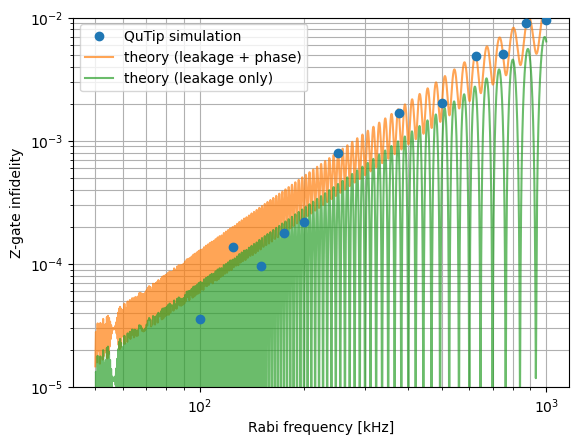

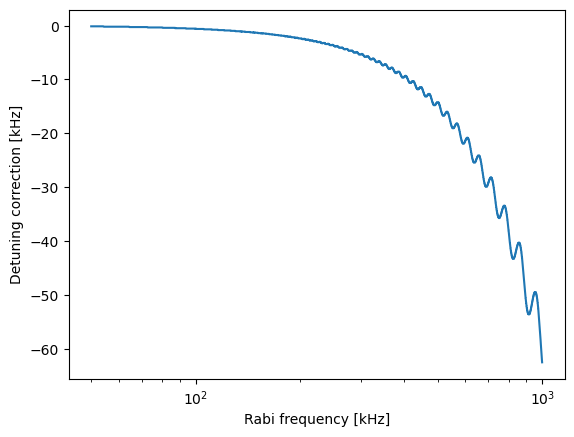

In [22]:
optimal_detuning_idxs = np.argmax(all_fidelities, axis=0)
optimal_fidelities = np.array([all_fidelities[idx, i] for i, idx in enumerate(optimal_detuning_idxs.tolist())])
optimal_detunings = np.array([detunings[idx] for idx in optimal_detuning_idxs.tolist()])

plt.figure()
plt.plot(np.array(rabi_freqs) * 1e3, 1-np.array(fidelities), 'o', zorder=999, label='QuTip simulation')
plt.plot(Omega_1_arr * 1e3, 1-unoptimal_fidelities, alpha=0.7, label='theory (leakage + phase)')
plt.plot(Omega_1_arr * 1e3, 1-optimal_fidelities, alpha=0.7, label=r'theory (leakage only)')
# plt.plot(Omega_1_arr * 1e3, (Omega_1_arr / np.sqrt(Omega_1_arr**2 + detuning_0**2))**2, '--', color='black')

plt.xlabel('Rabi frequency [kHz]')
plt.ylabel('Z-gate infidelity')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-5, 1e-2)
plt.legend()
plt.grid(which='both')

plt.figure()
plt.plot(Omega_1_arr * 1e3, optimal_detunings * 1e3)
plt.xlabel('Rabi frequency [kHz]')
plt.ylabel('Detuning correction [kHz]')
plt.xscale('log')

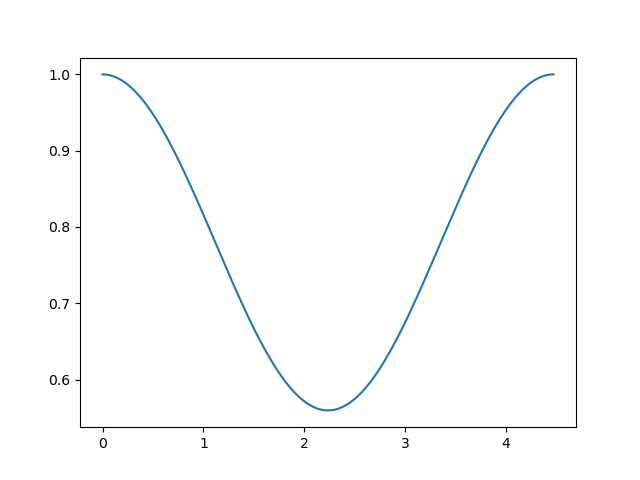

In [463]:
Omega = 0.933312
Delta = -51.84 * 1e-3 - 1000e-3

Delta_0 = 8.398303191204183 + Delta
Delta_1 = Delta

Omega_eff = np.sqrt(Omega**2 + Delta_1**2)
gate_time = 2 * np.pi / Omega_eff

ts = np.linspace(0, gate_time, 1000)
phase_0 = phase(Omega, Delta_0, ts)
phase_1 = phase(Omega, Delta_1, ts)

plt.figure()

# plt.plot(ts, np.abs(phase_0)**2)
plt.plot(ts, np.abs(phase_1)**2)
# plt.plot(ts, (np.angle(phase_1) - np.angle(phase_0))/np.pi)

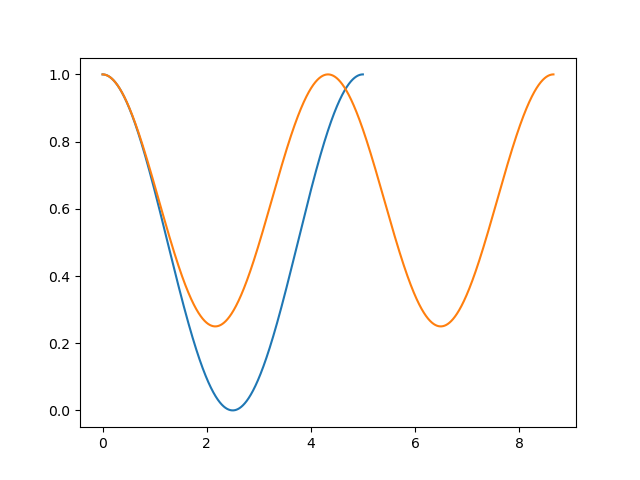

In [299]:
n = 2
m = 1

plt.figure()

Omega = 2 * np.pi * 0.2


Delta = 0
Omega_tilde = np.sqrt(Omega**2 + Delta**2)
gate_time = 2 * np.pi / Omega_tilde
ts = np.linspace(0, gate_time, 10000)
plt.plot(ts, np.abs(phase(Omega, Delta, ts))**2)

Delta = Omega * m / np.sqrt(n**2 - m**2)
Omega_tilde = np.sqrt(Omega**2 + Delta**2)
gate_time = 2 * np.pi * n / Omega_tilde
ts = np.linspace(0, gate_time, 10000)

plt.plot(ts, np.abs(phase(Omega, Delta, ts))**2)
    # plt.plot(ts, np.abs(phase(Omega, Delta + 2 * np.pi * 8.4, ts)))

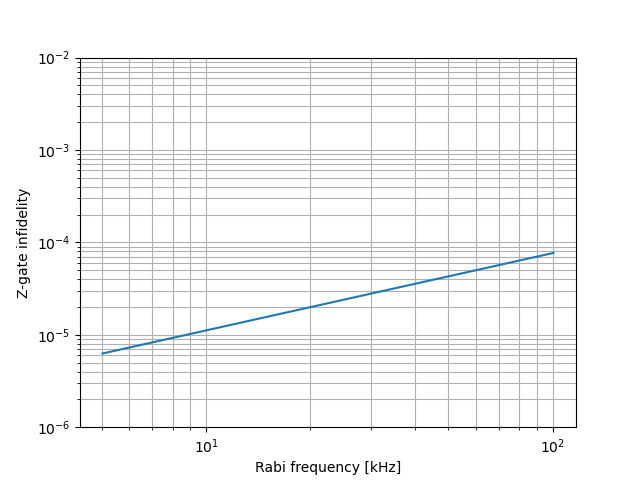

In [300]:
Omega_1_arr = 2 * np.pi * np.linspace(0.05, 1, 2)

n = 50
m = 49

Delta = Omega_1_arr * m / np.sqrt(n**2 - m**2)
detuning_0 = 2 * np.pi * 8.398303191204183 + Delta
detuning_1 = Delta
Omega_1_tilde_arr = np.sqrt(Omega_1_arr**2 + detuning_1**2)

# Omega_0_arr = np.sqrt(Omega_1_arr**2 + detuning_0**2)

def phase(Omega, Delta, t):
    Omega_tilde = np.sqrt(Omega**2 + Delta**2)
    return np.exp(1j * Delta * t / 2) * (np.cos(Omega_tilde * t / 2) - \
        1j * Delta / Omega_tilde * np.sin(Omega_tilde * t / 2))
    
gate_time = 2 * np.pi * n / Omega_1_tilde_arr
phase_0 = phase(Omega_1_arr, detuning_0, gate_time)
phase_1 = phase(Omega_1_arr, detuning_1, gate_time)

eff_rabi_freq = 1 / gate_time

rho_00 = phase_0 * phase_0.conjugate()
rho_01 = 1 * phase_1.conjugate()
rho_10 = phase_1 * 1
rho_11 = phase_1 * phase_1.conjugate()


def calculate_fidelity(actual_superop: Qobj, ideal_superop: Qobj):
    vec = np.array(actual_superop[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    process_fidelity = 1/4 * Qobj(ideal_superop.dag()[:,:] @ actual_superop[:,:]).tr()
    return np.real((2 * process_fidelity + 1 - leakage) / 3)

ideal_gate = Qobj(np.array([
    [1, 0, 0, 0],
    [0,-1, 0, 0],
    [0, 0,-1, 0],
    [0, 0, 0, 1]
]))

fidelities_calculated = []
for i in range(rho_00.shape[0]):
    super_op = Qobj(np.array([
        [rho_00[i], 0, 0, 0],
        [0, rho_10[i], 0, 0],
        [0, 0, rho_01[i], 0],
        [0, 0, 0, rho_11[i]]
    ]))

    fidelity = calculate_fidelity(super_op, ideal_gate)
    fidelities_calculated.append(fidelity)
    
fidelities_calculated = np.array(fidelities_calculated)

plt.figure()
plt.plot(eff_rabi_freq * 1e3, 1-fidelities_calculated)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Rabi frequency [kHz]')
plt.ylabel('Z-gate infidelity')
plt.ylim(1e-6, 1e-2)
plt.grid(which='both')

In [390]:
def calculate_E_field(power, beam_waist):
    intensity = 2 * power / (np.pi * beam_waist**2)
    E_field = np.sqrt(2 * intensity / (constants.c * constants.epsilon_0))
    return E_field

def calculate_rabi_frequency(dipole_matrix_element, E_field):
    return dipole_matrix_element * E_field / constants.hbar

def simulate_raman_gate(
    power_649: float,  # Watts
    power_770: float,  # Watts
    w0_649: float,  # meters
    w0_770: float,  # meters
    polarization_649: str,  # 'pi', 'sigma_plus'
    polarization_770: str,  # 'pi', 'sigma_plus'
    detuning: float,  # Hz
    detuning_offset: float,  # Hz
    initial_states: list[str],  # ['00', '01', '10', '11'] or any subset
    num_steps: int,
    gate_time: float = None
):
    
    
    freq_scale = 1e9  # GHz
    
    # =========================
    # Initialize energy levels 
    # =========================
    # NOTE: hard-coded for 5G magnetic field
    
    levels = [
        # 3P0 sublevels
        {'level': '3P0', 'F': 1/2, 'mF': 1/2,  'energy_Hz': 0},
        {'level': '3P0', 'F': 1/2, 'mF': -1/2, 'energy_Hz': 3749.528976851414},
        # 3S1 sublevels
        {'level': '3S1', 'F': 1/2, 'mF': 1/2,  'energy_Hz': 461850274160685.7},
        {'level': '3S1', 'F': 1/2, 'mF': -1/2, 'energy_Hz': 461850292913971.44},
        # {'level': '3S1', 'F': 3/2, 'mF': 3/2,  'energy_Hz': 461860484233885.6},
        {'level': '3S1', 'F': 3/2, 'mF': 1/2,  'energy_Hz': 461860493612403.4},
        {'level': '3S1', 'F': 3/2, 'mF': -1/2, 'energy_Hz': 461860502990920.8},
        # {'level': '3S1', 'F': 3/2, 'mF': -3/2, 'energy_Hz': 461860512369438.56},
        # 3P2 sublevels
        # {'level': '3P2', 'F': 3/2, 'mF': 3/2,  'energy_Hz': 72602523903671.75},
        # {'level': '3P2', 'F': 3/2, 'mF': 1/2,  'energy_Hz': 72602536499251.66},
        # {'level': '3P2', 'F': 3/2, 'mF': -1/2, 'energy_Hz': 72602549094831.69},
        # {'level': '3P2', 'F': 3/2, 'mF': -3/2, 'energy_Hz': 72602561690411.6},
        # {'level': '3P2', 'F': 5/2, 'mF': 5/2,  'energy_Hz': 72609214146883.69},
        # {'level': '3P2', 'F': 5/2, 'mF': 3/2,  'energy_Hz': 72609222545186.78},
        {'level': '3P2', 'F': 5/2, 'mF': 1/2,  'energy_Hz': 72609230943489.86},
        {'level': '3P2', 'F': 5/2, 'mF': -1/2, 'energy_Hz': 72609239341793.05},
        # {'level': '3P2', 'F': 5/2, 'mF': -3/2, 'energy_Hz': 72609247740096.14},
        # {'level': '3P2', 'F': 5/2, 'mF': -5/2, 'energy_Hz': 72609256138399.22},
    ]

    N = len(levels)
    basis_states = []
    for i, level in enumerate(levels):
        new_row = level.copy()
        new_row['basis'] = basis(N, i)
        basis_states.append(new_row)
    basis_states = pd.DataFrame(basis_states)
    
    # set intermediate and excited states for Raman gate
    # depending on the polarization of 649 and 770
    if polarization_649 == 'pi':
        q1 = 0
    elif polarization_649 == 'sigma_plus':
        q1 = 1
    else:
        raise ValueError(f'Invalid 649 polarization: {polarization_649}')
    if polarization_770 == 'pi':
        q2 = 0
    elif polarization_770 == 'sigma_plus':
        q2 = 1
    else:
        raise ValueError(f'Invalid 649 polarization: {polarization_770}')
    reference_state_3s1 = basis_states[(basis_states['level'] == '3S1') & \
                                       (basis_states['F'] == 1.5) & \
                                       (basis_states['mF'] == (0.5 + q1))]
    reference_state_3p2 = basis_states[(basis_states['level'] == '3P2') & \
                                       (basis_states['F'] == 2.5) & \
                                       (basis_states['mF'] == (0.5 + q1 + q2))]
        
    # ==============================
    # matrix elements [atomic units]
    # ==============================
    
    # level1 = 3P0 -> level2 = 3S1
    pi_matrix_elements_649 = [
        {'F1': 1/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 0.660000},
        {'F1': 1/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': -0.660000},
        {'F1': 1/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': -0.933381},
        {'F1': 1/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': -0.933381},
    ]
    sigma_p_matrix_elements_649 = [
        {'F1': 1/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': 1/2, 'matrix_element': 0.933381},
        {'F1': 1/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': 1/2, 'matrix_element': 0.660000},
        {'F1': 1/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 3/2, 'matrix_element': 1.143154},
    ]
    # level1 = 3P2 -> level2 = 3S1 
    pi_matrix_elements_770 = [
        # {'F1': 3/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 1.683333},
        # {'F1': 3/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 1.683333},
        # {'F1': 3/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 3/2, 'matrix_element': -0.714178},
        # {'F1': 3/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': -0.238059},
        # {'F1': 3/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 0.238059},
        # {'F1': 3/2, 'F2': 3/2, 'mF1': -3/2, 'mF2': -3/2, 'matrix_element': 0.714178},
        # {'F1': 5/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 3/2, 'matrix_element': 1.428356},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 1.749371},
        # {'F1': 5/2, 'F2': 3/2, 'mF1': -3/2, 'mF2': -3/2, 'matrix_element': 1.428356},
    ]
    sigma_p_matrix_elements_770 = [
        {'F1': 3/2, 'F2': 1/2, 'mF1': 3/2, 'mF2': 1/2, 'matrix_element': 2.061654},
        {'F1': 3/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': -1/2, 'matrix_element': 1.190296},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 1/2, 'matrix_element': 0.583124},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': -1/2, 'matrix_element': 0.673333},
        {'F1': 3/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -3/2, 'matrix_element': 0.583124},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 5/2, 'mF2': 3/2, 'matrix_element': 2.258429},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': -1/2, 'matrix_element': 1.236992},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -3/2, 'matrix_element': 0.714178},
    ]
    
    if polarization_649 == 'pi':
        matrix_elements_649 = pi_matrix_elements_649
    elif polarization_649 == 'sigma_plus':
        matrix_elements_649 = sigma_p_matrix_elements_649
        
    if polarization_770 == 'pi':
        matrix_elements_770 = pi_matrix_elements_770
    elif polarization_649 == 'sigma_plus':
        matrix_elements_770 = sigma_p_matrix_elements_770

    # atomic units for dipole matrix element
    dipole_moment_si = constants.physical_constants['Bohr radius'][0] * constants.e

    # compute electric field at beam waist of 649nm laser
    E_field_649 = calculate_E_field(power_649, w0_649)
    # compute Rabi frequencies [Hz] for each transition
    rabi_frequencies_649 = []
    for row in matrix_elements_649:
        # copy row and remove matrix element
        new_row = row.copy()
        new_row.pop('matrix_element')
        # compute rabi frequency
        matrix_element = row['matrix_element'] * dipole_moment_si
        new_row['rabi_frequency'] = calculate_rabi_frequency(matrix_element, E_field_649)
        rabi_frequencies_649.append(new_row)
        
    # compute electric field at beam waist of 649nm laser
    E_field_770 = calculate_E_field(power_770, w0_770)
    # compute Rabi frequencies [Hz] for each transition
    rabi_frequencies_770 = []
    for row in matrix_elements_770:
        # copy row and remove matrix element
        new_row = row.copy()
        new_row.pop('matrix_element')
        # compute rabi frequency
        matrix_element = row['matrix_element'] * dipole_moment_si
        new_row['rabi_frequency'] = calculate_rabi_frequency(matrix_element, E_field_770)
        rabi_frequencies_770.append(new_row)
        
    # =====================
    # Construct Hamiltonian
    # =====================
    
    # Calculate light shift compensation
    Delta_LS = 0
    for transition in rabi_frequencies_649:
        if transition['F1'] == 1/2 and transition['mF1'] == 1/2:
            Delta_LS += transition['rabi_frequency']**2 / (4 * detuning)
    for transition in rabi_frequencies_770:
        if transition['F1'] == reference_state_3p2['F'].values[0] and transition['mF1'] == reference_state_3p2['mF'].values[0]:
            Delta_LS -= transition['rabi_frequency']**2 / (4 * detuning)
    # Add offset (for sweeping)
    Delta_LS += detuning_offset
    # Rescale
    Delta_LS /= freq_scale
    
    # Initialize Hamiltonian
    H = 0

    # 3P0 -> 3S1
    for transition in rabi_frequencies_649:
        Omega = transition['rabi_frequency'] / freq_scale
        state1 = basis_states[(basis_states['level'] == '3P0') & \
                            (basis_states['F'] == transition['F1']) & \
                            (basis_states['mF'] == transition['mF1'])]
        state2 = basis_states[(basis_states['level'] == '3S1') & \
                            (basis_states['F'] == transition['F2']) & \
                            (basis_states['mF'] == transition['mF2'])]
        # add coupling term
        basis1 = state1['basis'].values[0]
        basis2 = state2['basis'].values[0]
        coupling_term = (Omega / 2) * (basis1 * basis2.dag() + basis2 * basis1.dag())
        H += coupling_term
        
    # 3S1 -> 3P2
    for transition in rabi_frequencies_770:
        Omega = transition['rabi_frequency'] / freq_scale
        state1 = basis_states[(basis_states['level'] == '3P2') & \
                            (basis_states['F'] == transition['F1']) & \
                            (basis_states['mF'] == transition['mF1'])]
        state2 = basis_states[(basis_states['level'] == '3S1') & \
                            (basis_states['F'] == transition['F2']) & \
                            (basis_states['mF'] == transition['mF2'])]
        # add coupling term
        basis1 = state1['basis'].values[0]
        basis2 = state2['basis'].values[0]
        coupling_term = (Omega / 2) * (basis1 * basis2.dag() + basis2 * basis1.dag())
        H += coupling_term
        
    # add detunings
    for state in basis_states.to_records():
        if state['level'] in ['3P0', '3P2']:
            H += (detuning / freq_scale) * state['basis'] * state['basis'].dag()
        if state['level'] == '3S1':
            ref_detuning = (reference_state_3s1['energy_Hz'].values[0] - state['energy_Hz']) / freq_scale
            H += 2 * np.pi * ref_detuning * state['basis'] * state['basis'].dag()
        if state['level'] == '3P2':
            ref_detuning = (reference_state_3p2['energy_Hz'].values[0] - state['energy_Hz']) / freq_scale
            H += 2 * np.pi * ref_detuning * state['basis'] * state['basis'].dag()
            # add light shift compensation for resonance
            H += Delta_LS * state['basis'] * state['basis'].dag()
            
    # =======================
    # Simulate time evolution
    # =======================

    # calculate gate time
    gi_rabi_freq = [transition['rabi_frequency'] for transition in rabi_frequencies_649 \
        if transition['F1'] == 1/2 and transition['mF1'] == 1/2 and \
        transition['F2'] == reference_state_3s1['F'].values[0] and \
        transition['mF2'] == reference_state_3s1['mF'].values[0]][0]
    ie_rabi_freq = [transition['rabi_frequency'] for transition in rabi_frequencies_770 \
        if transition['F1'] == reference_state_3p2['F'].values[0] and \
        transition['mF1'] == reference_state_3p2['mF'].values[0] and \
        transition['F2'] == reference_state_3s1['F'].values[0] and \
        transition['mF2'] == reference_state_3s1['mF'].values[0]][0]
    
    Delta_avg = (detuning + (detuning + Delta_LS)) / 2
    raman_rabi_freq = (gi_rabi_freq * ie_rabi_freq) / (2 * Delta_avg) / freq_scale
    detuned_raman_rabi_freq = np.sqrt(raman_rabi_freq**2 + (detuning_offset/freq_scale)**2)
    print(f'Raman Rabi frequency: {np.abs(raman_rabi_freq) / 2 / np.pi * freq_scale / 1e6} MHz')
    print(f'Detuned Rabi frequency: {np.abs(detuned_raman_rabi_freq) / 2 / np.pi * freq_scale / 1e6} MHz')
    raman_gate_time = np.abs(2 * np.pi / detuned_raman_rabi_freq)
    
    qubit_basis_0 = basis_states[(basis_states['level'] == '3P0') & \
                                 (basis_states['F'] == 1/2) & \
                                 (basis_states['mF'] == -1/2)]['basis'].values[0]
    qubit_basis_1 = basis_states[(basis_states['level'] == '3P0') & \
                                 (basis_states['F'] == 1/2) & \
                                 (basis_states['mF'] == 1/2)]['basis'].values[0]

    rho_inital_dict = {
        '00': qubit_basis_0 * qubit_basis_0.dag(), 
        '01': qubit_basis_0 * qubit_basis_1.dag(), 
        '10': qubit_basis_1 * qubit_basis_0.dag(), 
        '11': qubit_basis_1 * qubit_basis_1.dag()
    }
    
    # Time vector
    if gate_time is not None:
        t_max = gate_time * freq_scale
    else:
        t_max = 2.1 * raman_gate_time
    t_list = np.linspace(0, t_max, num_steps)

    # Expectation operators
    e_ops = [state['basis'] * state['basis'].dag() for state in basis_states.to_records()]

    # Solve for the time evolution
    result_dict = {}
    for state in initial_states:
        result = mesolve(H, rho_inital_dict[state], t_list, e_ops=e_ops, options=dict(store_states=True))
        result_dict[state] = result
        
    # Construct return value
    output = {
        'basis_states': basis_states,
        't_list': t_list,
        'results': result_dict
    }
        
    return output

In [387]:
n = 2
Omega = 5.4211
delta = 8.398303191204183
Delta_plus = (-2 * delta + np.sqrt(4 * delta**2 - 4 * (1 - n**2) * (delta**2 + (1 - n**2) * Omega**2))) / (2 * (1 - n**2))
Delta_minus = (-2 * delta - np.sqrt(4 * delta**2 - 4 * (1 - n**2) * (delta**2 + (1 - n**2) * Omega**2))) / (2 * (1 - n**2))

Delta = Delta_plus
# print(Delta_minus)

Omega_eff_0 = np.sqrt(Omega**2 + (Delta + delta)**2)
Omega_eff_1 = np.sqrt(Omega**2 + Delta**2)

print(f"{Omega = :.5f} MHz")
print(f"{Delta = :.5f} MHz")
print(f"{Omega_eff_0 = :.5f} MHz")
print(f"{Omega_eff_1 = :.5f} MHz")

gate_time = 4 * np.pi / Omega_eff_1

phase_0 = np.exp(1j * (Delta + delta) * gate_time / 2) * (np.cos(Omega_eff_0 * gate_time / 2) - \
                                                          1j * (Delta + delta) / Omega_eff_0 * np.sin(Omega_eff_0 * gate_time / 2))
phase_1 = np.exp(1j * Delta * gate_time / 2) * (np.cos(Omega_eff_1 * gate_time / 2) - \
                                                1j * Delta / Omega_eff_1 * np.sin(Omega_eff_1 * gate_time / 2))
phase_delta = np.angle(phase_1 / phase_0)
print(np.abs(phase_delta) / np.pi)

Omega = 5.42110 MHz
Delta = 1.39979 MHz
Omega_eff_0 = 11.19781 MHz
Omega_eff_1 = 5.59890 MHz
0.999980699298498


In [402]:
eps = 0.15

power_649 = 634.142e-3  # 649nm power [W]
power_770 = 634.142e-3  # 770nm power [W]
# power_649 = (1 + eps) * 183e-3  # 649nm power [W]
# power_770 = (1 + eps) * 183e-3  # 770nm power [W]
w0_649 = 500e-6  # 649nm beam waist [m]
w0_770 = 500e-6  # 770nm beam waist [m]
polarization_649 = 'pi'
polarization_770 = 'pi'
detuning = 2 * np.pi * 30 * 1e9  # Hz
initial_states = ['00', '01', '10', '11']
num_steps = 1000

# detuning_offset = 2 * np.pi * 1.1309094817262229 * 1e6 # 2 * np.pi * 0.0725 * 1e6  # Hz
# detuning_offset = -1 * 2 * np.pi * (1.194 - 0.54) * (1 + eps) * 1e6
detuning_offset = -1 * 2 * np.pi * (1.39979 - 0.4) * 1e6

output = simulate_raman_gate(
    power_649=power_649,
    power_770=power_770,
    w0_649=w0_649,
    w0_770=w0_770,
    polarization_649=polarization_649,
    polarization_770=polarization_770,
    detuning=detuning,
    detuning_offset=detuning_offset,
    initial_states=initial_states,
    num_steps=num_steps,
    # gate_time=982.6886104804524e-9
)

Raman Rabi frequency: 5.421104988269772 MHz
Detuned Rabi frequency: 5.512527490901376 MHz


358.0705723702646


Text(0.5, 0, 'Time [ns]')

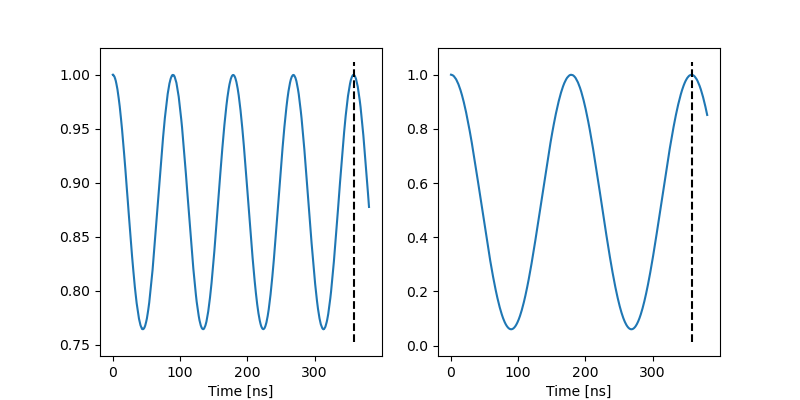

In [407]:
%matplotlib widget

basis_states = output['basis_states']
results = output['results']

ground_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P0' and state['F'] == 0.5 and state['mF'] == -0.5][0]
ground_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P0' and state['F'] == 0.5 and state['mF'] == 0.5][0]

intermediate_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3S1' and state['F'] == 1.5 and state['mF'] == -0.5][0]
intermediate_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3S1' and state['F'] == 1.5 and state['mF'] == 0.5][0]

excited_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P2' and state['F'] == 2.5 and state['mF'] == -0.5][0]
excited_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P2' and state['F'] == 2.5 and state['mF'] == 0.5][0]


ts = output['t_list']
ys_0 = results['00'].expect[ground_0_idx]
ys_1 = results['11'].expect[ground_1_idx]
gate_end_idx = num_steps//2 + np.argmax(ys_1[num_steps//2:])
print(ts[gate_end_idx])

fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))

ax[0].plot(ts, ys_0)
ax[1].plot(ts, ys_1)

ax[0].vlines(ts[gate_end_idx], *ax[0].get_ylim(), linestyle='--', color='black')
ax[1].vlines(ts[gate_end_idx], *ax[1].get_ylim(), linestyle='--', color='black')



# det = 1.39979 + transition
# omega = 5.598909834775321
# pop_0 = 1 - omega**2 / (omega**2 + det**2)
# pop_1 = 1 - omega**2 / (omega**2 + 1.39979**2)
# ax[0].hlines(pop_0, *ax[0].get_xlim(), linestyle='--', color='black')
# ax[1].hlines(pop_1, *ax[1].get_xlim(), linestyle='--', color='black')


ax[0].set_xlabel('Time [ns]')
ax[1].set_xlabel('Time [ns]')

In [410]:
def calculate_fidelity(actual_superop: Qobj, ideal_superop: Qobj):
    vec = np.array(actual_superop[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    process_fidelity = 1/4 * Qobj(ideal_superop.dag()[:,:] @ actual_superop[:,:]).tr()
    return np.real((2 * process_fidelity + 1 - leakage) / 3)

rho_final = {state: result.states[gate_end_idx] for state, result in results.items()}
subspace_vector_final = {state: operator_to_vector(Qobj(rho[:2,:2]))[::-1,:] for state, rho in rho_final.items()}

super_op_sim = Qobj(np.column_stack((
    subspace_vector_final['00'], 
    subspace_vector_final['10'], 
    subspace_vector_final['01'], 
    subspace_vector_final['11'])))

ideal_gate = Qobj(np.array([
    [1, 0, 0, 0],
    [0,-1, 0, 0],
    [0, 0,-1, 0],
    [0, 0, 0, 1]
]))

fidelity = calculate_fidelity(super_op_sim, ideal_gate)
fidelity
# super_op_sim

0.9997248932966915

In [ ]:
-0.978-0.143j

In [ ]:
# %matplotlib inline

# fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(7,5))

# for ys, state in zip(result00.expect, basis_states.to_records()):
#     if state['level'] == '3P0':
#         i = 0
#         j = 0
#     if state['level'] == '3S1':
#         i = 1
#         j = 0 if state['F'] == 0.5 else 1
#     if state['level'] == '3P2':
#         i = 2
#         j = 0 if state['F'] == 1.5 else 1
#     if np.max(ys) != 0:
#         ax[i,j].plot(t_list, ys, label=f"mF={state['mF']}")
#         ax[i,j].set_xlabel('Time [ns]')
        
# ax[0,0].set_title('3P0, F=0.5')
# ax[1,0].set_title('3S1, F=0.5')
# ax[1,1].set_title('3S1, F=1.5')
# ax[2,0].set_title('3P2, F=1.5')
# ax[2,1].set_title('3P2, F=2.5')

# ax[0,0].legend()
# ax[1,0].legend()
# ax[1,1].legend()
# ax[2,0].legend()
# ax[2,1].legend()

# fig.tight_layout()

In [69]:
ground_0 = basis(4, 0)
ground_1 = basis(4, 1)
intermediate = basis(4, 2)
excited = basis(4, 3)

Omega_gi = 2 * np.pi * 0.3
Omega_ie = 2 * np.pi * 0.3
Delta = 2 * np.pi * 20
gate_time = None
Delta_LS = Omega_gi**2 / (4 * Delta) - Omega_ie**2 / (4 * Delta)

H = 0
H += Delta * (ground_0 * ground_0.dag() + ground_1 * ground_1.dag())
H += (Delta + Delta_LS) * excited * excited.dag()
H += Omega_gi / 2 * (ground_1 * intermediate.dag() + intermediate * ground_1.dag())
H += Omega_ie / 2 * (excited * intermediate.dag() + intermediate * excited.dag())

if not gate_time:
    rabi_freq = Omega_gi * Omega_ie / 2 / Delta
    gate_time = 2 * np.pi / rabi_freq

num_steps = 2000
t_list = np.linspace(0, gate_time, num_steps)

rho_initial_dict = {
    '00': ground_0 * ground_0.dag(),
    '01': ground_0 * ground_1.dag(),
    '10': ground_1 * ground_0.dag(),
    '11': ground_1 * ground_1.dag()
}

proj_g = ground_1 * ground_1.dag()
proj_i = intermediate * intermediate.dag()
proj_e = excited * excited.dag()

results = {}
for state, rho_initial in rho_initial_dict.items():
    result = mesolve(
        H, rho_initial, t_list,
        e_ops=[rho_initial_dict['00'], proj_g, proj_i, proj_e],
        options=dict(store_final_state=True))
    results[state] = result

0.25


Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j -1.        -3.28426265e-06j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
  -1.        +3.28426265e-06j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.99999789+0.00000000e+00j]]

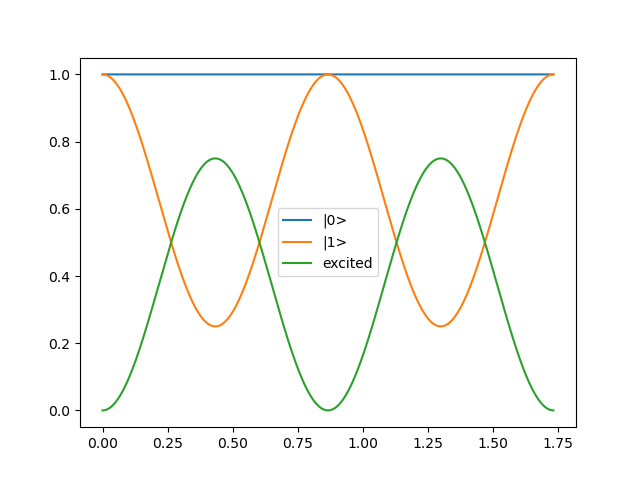

In [185]:
%matplotlib widget

ground_0 = basis(3, 0)
ground_1 = basis(3, 1)
excited = basis(3, 2)

Omega = 2 * np.pi * 1
Delta = 2 * np.pi * 1 / np.sqrt(3)

print((Delta / np.sqrt(Omega**2 + Delta**2))**2)
gate_time = None

H = 0
H += Delta * excited * excited.dag()
H += Omega / 2 * (ground_1 * excited.dag() + excited * ground_1.dag())

if not gate_time:
    rabi_freq = np.sqrt(Omega**2 + Delta**2)
    gate_time = 2 * 2 * np.pi / rabi_freq

num_steps = 2000
t_list = np.linspace(0, gate_time, num_steps)

rho_initial_dict = {
    '00': ground_0 * ground_0.dag(),
    '01': ground_0 * ground_1.dag(),
    '10': ground_1 * ground_0.dag(),
    '11': ground_1 * ground_1.dag()
}

proj_g = ground_1 * ground_1.dag()
proj_e = excited * excited.dag()

results = {}
for state, rho_initial in rho_initial_dict.items():
    result = mesolve(
        H, rho_initial, t_list,
        e_ops=[rho_initial_dict['00'], proj_g, proj_e],
        options=dict(store_final_state=True))
    results[state] = result
    
plt.figure()
plt.plot(t_list, results['00'].expect[0], label='|0>')
plt.plot(t_list, results['11'].expect[1], label='|1>')
plt.plot(t_list, results['11'].expect[2], label='excited')
plt.legend()

def calculate_fidelity(actual_superop: Qobj, ideal_superop: Qobj):
    vec = np.array(actual_superop[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    process_fidelity = 1/4 * Qobj(ideal_superop.dag()[:,:] @ actual_superop[:,:]).tr()
    return np.real((2 * process_fidelity + 1 - leakage) / 3)

rho_final = {state: result.final_state for state, result in results.items()}
subspace_vector_final = {state: operator_to_vector(Qobj(rho[:2,:2]))[:,:] for state, rho in rho_final.items()}

super_op_sim = Qobj(np.column_stack((
    subspace_vector_final['00'], 
    subspace_vector_final['10'], 
    subspace_vector_final['01'], 
    subspace_vector_final['11'])))

# ideal_gate = Qobj(np.array([
#     [1, 0, 0, 0],
#     [0,-1, 0, 0],
#     [0, 0,-1, 0],
#     [0, 0, 0, 1]
# ]))

# ideal_gate = Qobj(np.array([
#     [1, 0, 0, 0],
#     [0,1j, 0, 0],
#     [0, 0,-1j, 0],
#     [0, 0, 0, 1]
# ]))

# fidelity = calculate_fidelity(super_op_sim, ideal_gate)
# fidelity
super_op_sim


In [469]:
(72609230943489.86 - 72602536499251.66) / 1e9

6.694444238203125

In [485]:
(461860493612403.4 - 461850274160685.7) / 1e9

10.2194517176875

In [489]:
Omega_649 = 2 * np.pi * 244.9489742783178 * 1e6
Omega_770 = 2 * np.pi * 244.9489742783178 * 1e6
Delta = 2 * np.pi * 30 * 1e9  # Hz

shift_649 = Omega_649**2 / (4 * Delta) + (Omega_649 * 0.660000 / 0.933)**2 / (4 * (Delta + 2 * np.pi * 10.22 * 1e9))
shift_770 = Omega_770**2 / (4 * Delta)

print(shift_649 / 1e3 / 2 / np.pi)
print(shift_770 / 1e3 / 2 / np.pi)
print((shift_649 - shift_770) / 1e3 / 2 / np.pi)

686.6266998305567
499.99999999999994
186.62669983055673
